In [17]:
!git add "/Users/tasha/Desktop/comento/mywork/notebooks/03_FastAPI_colab사용_샘플코드.ipynb"
!git commit -m "edit) tmux, streamlit :poop: " 
!git push origin main

[main 6518577] edit) tmux, streamlit :poop:
 1 file changed, 289 insertions(+), 54 deletions(-)
오브젝트 나열하는 중: 7, 완료.
오브젝트 개수 세는 중: 100% (7/7), 완료.
Delta compression using up to 8 threads
오브젝트 압축하는 중: 100% (4/4), 완료.
오브젝트 쓰는 중: 100% (4/4), 616.09 KiB | 7.80 MiB/s, 완료.
Total 4 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/tashapark/cctv_object_detection.git
   d67fd0e..6518577  main -> main


- fastapi는 무엇이고, 언제 사용을 하는지등 기본적인 이론도 같이 공부하면 좋을 것 같습니다.
  - FastAPI , uvicorn , ...

### 01. 필요한 라이브러리 설치

### 02. FastAPI 실행

- 학습때 설치했던 yolov5 폴더가 있는 경로로 이동해주세요.

In [7]:
cd /Users/tasha/Desktop/comento/mywork/models/yolov5

/Users/tasha/Desktop/comento/mywork/models/yolov5


- 2-1) 학습한 모델을 로드해줍니다.

In [8]:
import os
import torch
import uvicorn
import nest_asyncio

from PIL import Image
from io import BytesIO
from pyngrok import ngrok
from torchvision import transforms
from fastapi import FastAPI, File, UploadFile

In [9]:
# FastAPI 앱 생성
app = FastAPI()

# YOLOv5 모델 로드
model = torch.hub.load('yolov5', 'custom', path='/Users/tasha/Desktop/comento/mywork/models/yolov5/yolov5/runs/train/yolov5s_batch64_epoch102/weights/best.pt', source='local')  # 학습한 모델의 경로를 'path'인자에 넣어주세요 (ex, 'yolov5/runs/train/yolov5s_results4/weights/best.pt')
model.conf = 0.5  # 신뢰도 임계값 설정

# ngrok 인증 토큰 설정
#authtoken = "..." # 자신의 인증 토큰으로 변경하세요
#ngrok.set_auth_token(authtoken)

YOLOv5 🚀 v7.0-399-g8cc44963 Python-3.12.9 torch-2.6.0 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


### 2-2) fastapi 실행 함수 구현
- Input : 이미지 경로
- Output : 자유롭게 아이디어를 내서 결과를 출력시켜주세요.
  - 차량 정체 문제를 파악하기 위한 값으로 출력해주세요.
  - 예를 들어, 차량 개수 파악 / 차량 전체 면적 또는 비율 등 다양한 아이디어를 생각해서 구현해주세요.

In [10]:
import asyncio 

@app.post('/detect')
async def detect_api(file: UploadFile = File(...)):
    # 비동기적으로 파일 읽기
    image_bytes = await file.read()

    try:
        # ✅ RGB 형태로 이미지 열기
        image = Image.open(BytesIO(image_bytes)).convert("RGB")

        # ✅ YOLOv5 모델 추론
        results = model(image)
        df = results.pandas().xyxy[0]  # pandas DataFrame 변환

        # ✅ 차량 개수 및 전체 면적 비율 계산
        total_area = image.size[0] * image.size[1]  # 이미지 전체 면적
        vehicle_area = 0  # 차량이 차지하는 면적

        detections_list = []
        for _, row in df.iterrows():
            width = row['xmax'] - row['xmin']
            height = row['ymax'] - row['ymin']
            area = width * height
            vehicle_area += area  # 차량 영역 합산

            detections_list.append({
                "x1": float(row['xmin']),
                "y1": float(row['ymin']),
                "x2": float(row['xmax']),
                "y2": float(row['ymax']),
                "confidence": float(row['confidence']),
                "class": int(row['class']),
                "label": row['name']
            })

        # ✅ 차량 정체 분석 지표 추가
        congestion_info = {
            "total_vehicles": len(detections_list),  # 감지된 차량 개수
            "vehicle_area_ratio": vehicle_area / total_area  # 차량이 차지하는 면적 비율
        }

        return {"detections": detections_list, "congestion_info": congestion_info}

    except Exception as e:
        return {"error": "이미지 처리 실패", "details": str(e)}

# ✅ Jupyter Notebook & IPython 환경에서도 실행 가능하도록 수정
def run_server():
    config = uvicorn.Config(app, host="0.0.0.0", port=8000, log_level="info")
    server = uvicorn.Server(config)
    asyncio.create_task(server.serve())

if __name__ == "__main__":
    run_server()

# 아래 주소로 해야 api들어감 
#http://0.0.0.0:8000/docs

INFO:     Started server process [65831]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
/Users/tasha/Desktop/comento/mywork/models/yolov5/yolov5/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


INFO:     127.0.0.1:52589 - "POST /detect HTTP/1.1" 200 OK


/Users/tasha/Desktop/comento/mywork/models/yolov5/yolov5/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


INFO:     127.0.0.1:52629 - "POST /detect HTTP/1.1" 200 OK


/Users/tasha/Desktop/comento/mywork/models/yolov5/yolov5/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


INFO:     127.0.0.1:52816 - "POST /detect HTTP/1.1" 200 OK


/Users/tasha/Desktop/comento/mywork/models/yolov5/yolov5/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


INFO:     127.0.0.1:52849 - "POST /detect HTTP/1.1" 200 OK


/Users/tasha/Desktop/comento/mywork/models/yolov5/yolov5/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


INFO:     127.0.0.1:52900 - "POST /detect HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [65831]


In [11]:
import torch

print("PyTorch MPS 지원 여부:", torch.backends.mps.is_available())
print("현재 사용 중인 디바이스:", torch.device("mps") if torch.backends.mps.is_available() else "CPU")


PyTorch MPS 지원 여부: True
현재 사용 중인 디바이스: mps


#### 2-3) fastapi_server.py 파일로 만들기 

#### Q1. 여기가 계속 안되고.. 터미널에서 torch를 받고, 분명히 리스트에는 있는데..  => 결국 가상환경..문제인거죠?
- ++ 가상환경 생성하고 파이썬 재설치해야 하나요..?
- 제가 그냥.. 다른 거 깔고 했더니, 가상환경이 아닌 local/bin의 파이썬을 잡아서요..
  => 이 경우에는 가상환경을 다시 만드는 것 말고 기존 것 유지하는 방법은 없나요?
  
- 무중단 파이토치 버전 문제는 해결. 아래 로그는 기록용으로 두겠습니다
- ++ 버전 다시 받아서 해결함.
- pip install torch==2.5 torchvision==0.20

- 터미널에서.. 파이토치 버전이 부딪히나 봅니다..ㅠ
- tmux하려고 할 때 자꾸 안 되서... 그냥 주피터에서 돌렸습니다.
- 가상환경 문제같은데.. 우선은 그냥 제출합니다 ㅠㅠ

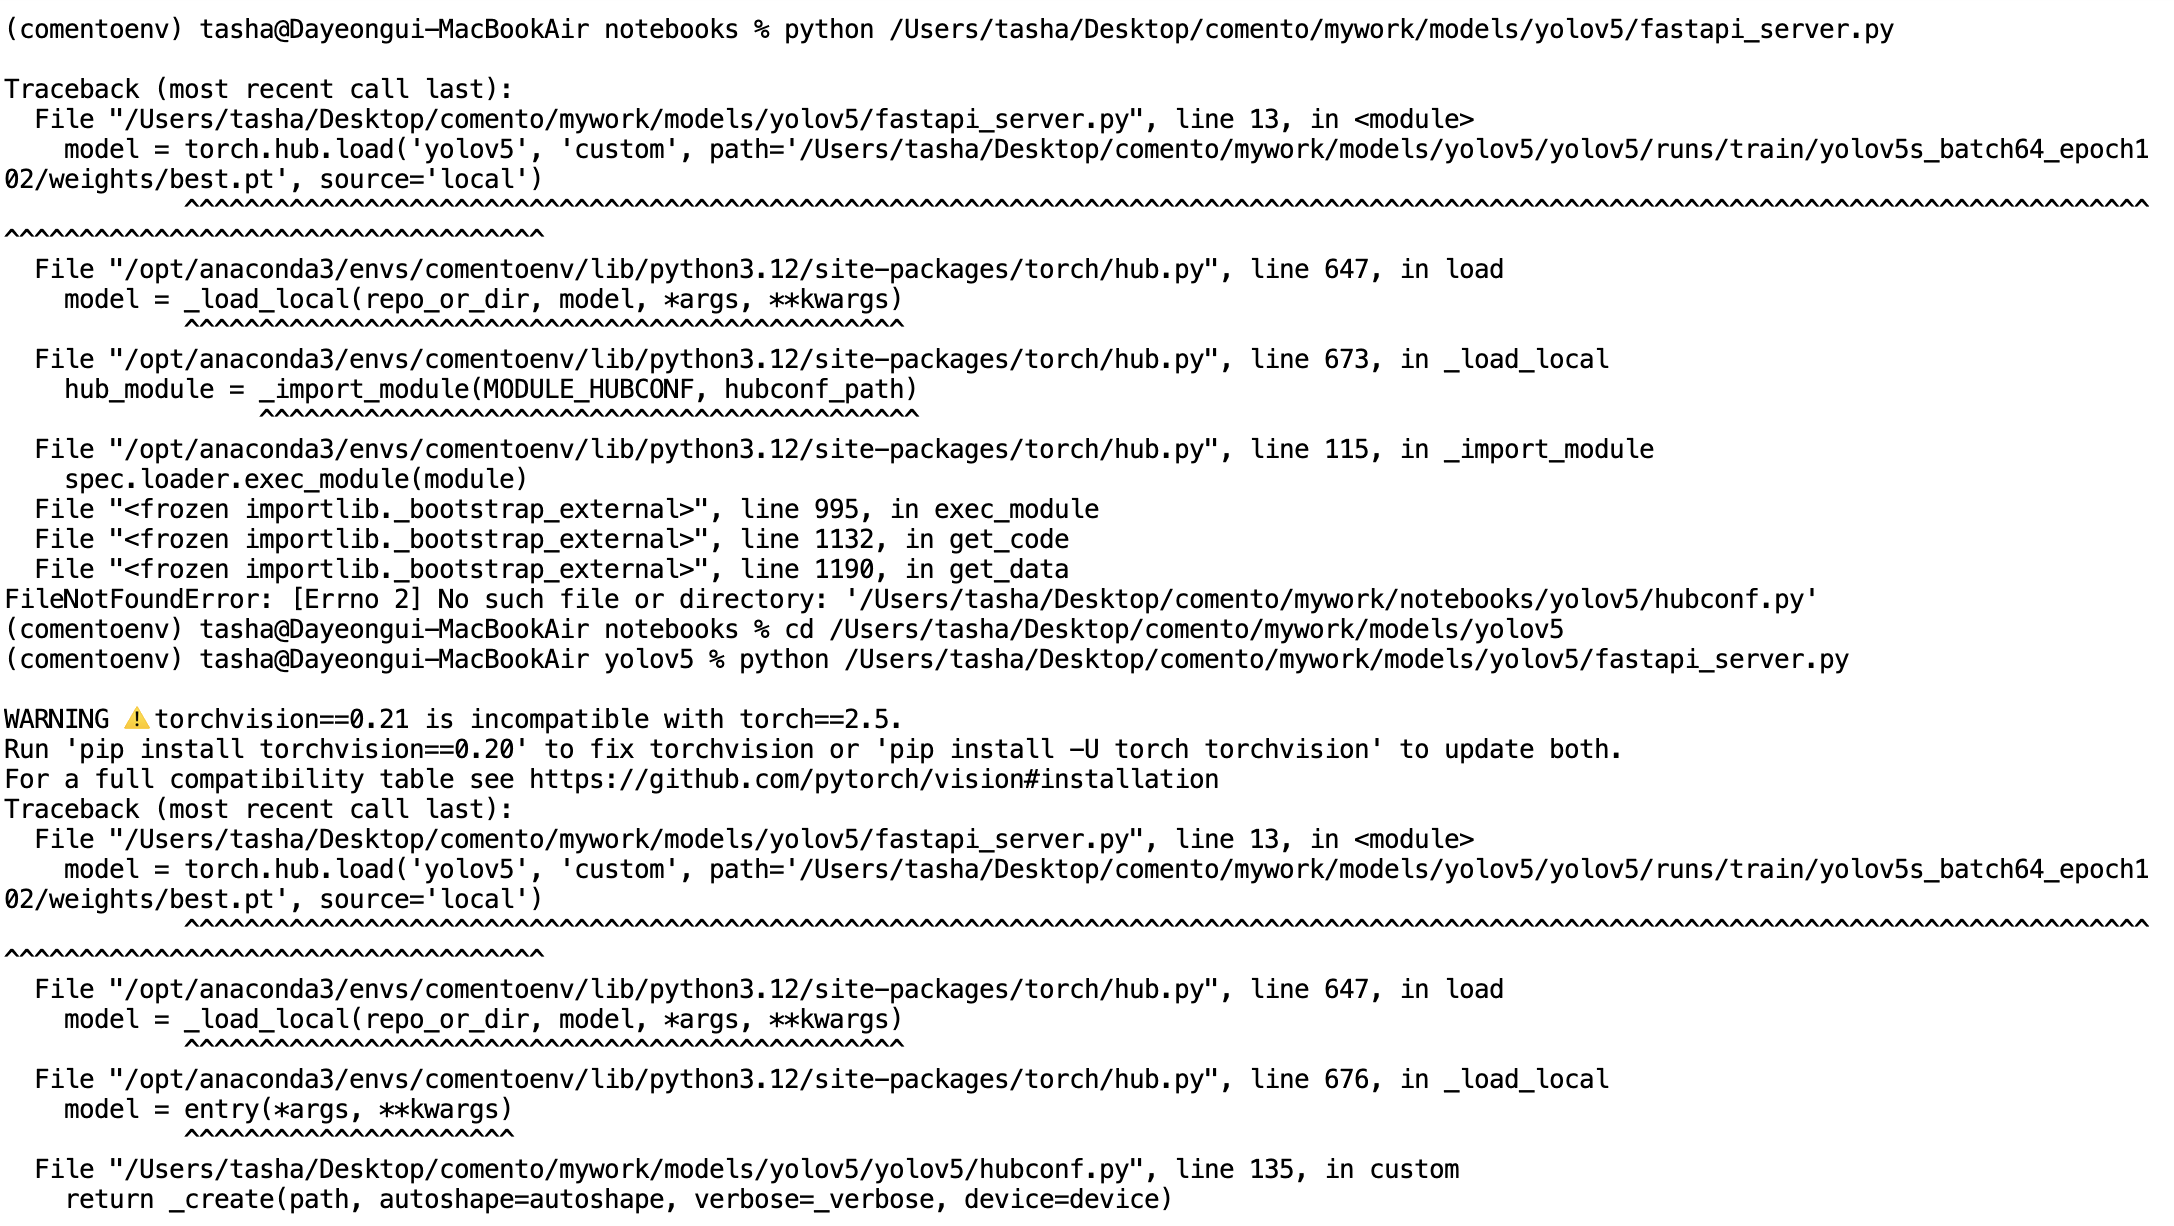
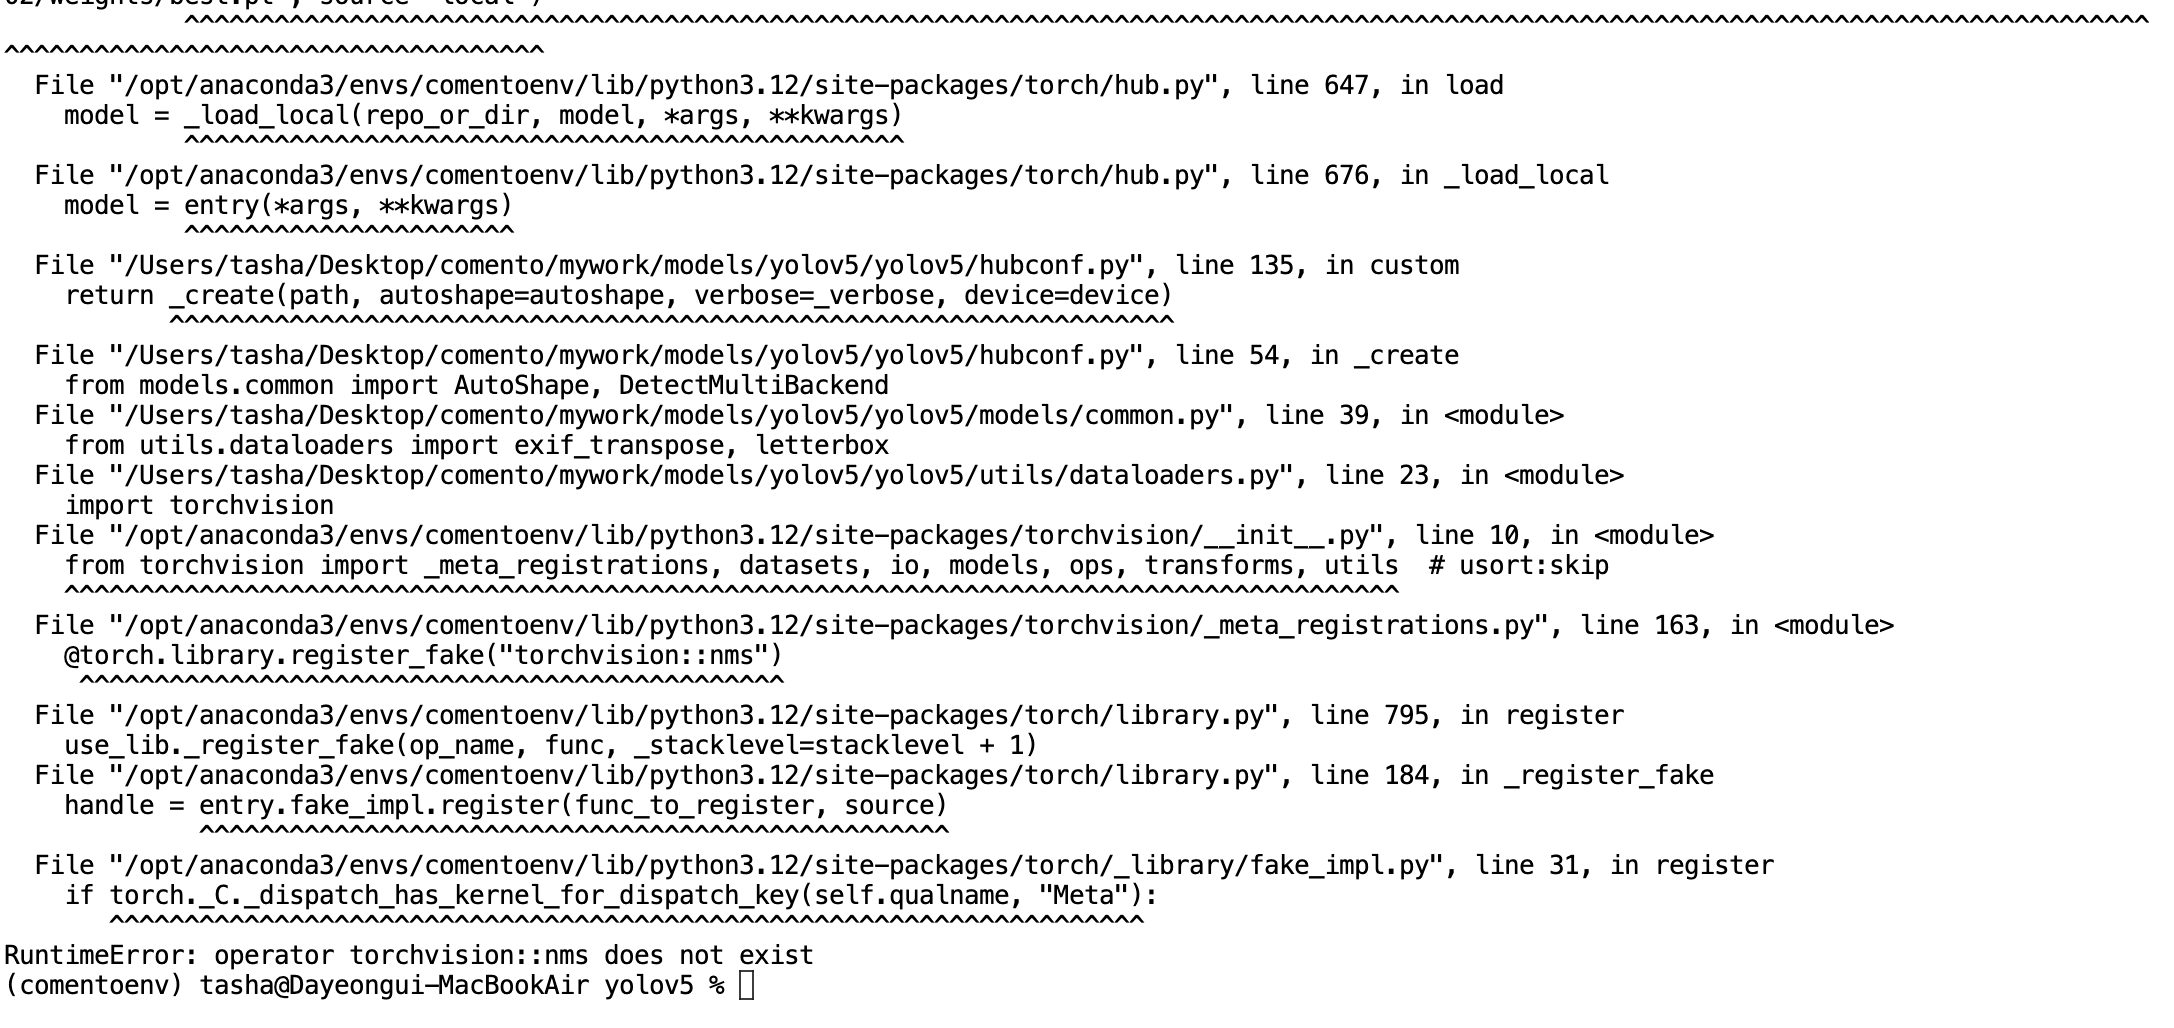

In [2]:
import os

# 저장할 경로 설정
save_path = "/Users/tasha/Desktop/comento/mywork/models/yolov5/fastapi_server.py"

# FastAPI 서버 코드
fastapi_code = """import os
import torch
import uvicorn
import asyncio
from PIL import Image
from io import BytesIO
from fastapi import FastAPI, File, UploadFile

# FastAPI 앱 생성
app = FastAPI()

# YOLOv5 모델 로드
model = torch.hub.load('yolov5', 'custom', path='/Users/tasha/Desktop/comento/mywork/models/yolov5/yolov5/runs/train/yolov5s_batch64_epoch102/weights/best.pt', source='local')
model.conf = 0.5  # 신뢰도 임계값 설정

@app.post('/detect')
async def detect_api(file: UploadFile = File(...)):
    image_bytes = await file.read()
    try:
        image = Image.open(BytesIO(image_bytes)).convert("RGB")
        results = model(image)
        df = results.pandas().xyxy[0]
        
        detections_list = [
            {"x1": float(row['xmin']), "y1": float(row['ymin']), "x2": float(row['xmax']),
             "y2": float(row['ymax']), "confidence": float(row['confidence']),
             "class": int(row['class']), "label": row['name']}
            for _, row in df.iterrows()
        ]
        return {"detections": detections_list}
    except Exception as e:
        return {"error": "이미지 처리 실패", "details": str(e)}

# 서버 실행 함수
def run_server():
    uvicorn.run(app, host="0.0.0.0", port=8000, log_level="info")

if __name__ == "__main__":
    run_server()
"""

# 파일 저장
with open(save_path, "w") as f:
    f.write(fastapi_code)

print(f"✅ FastAPI 서버 코드가 {save_path} 에 저장되었습니다!")

✅ FastAPI 서버 코드가 /Users/tasha/Desktop/comento/mywork/models/yolov5/fastapi_server.py 에 저장되었습니다!


#### 2-4) 무중단 터미널 코드 -> tmux

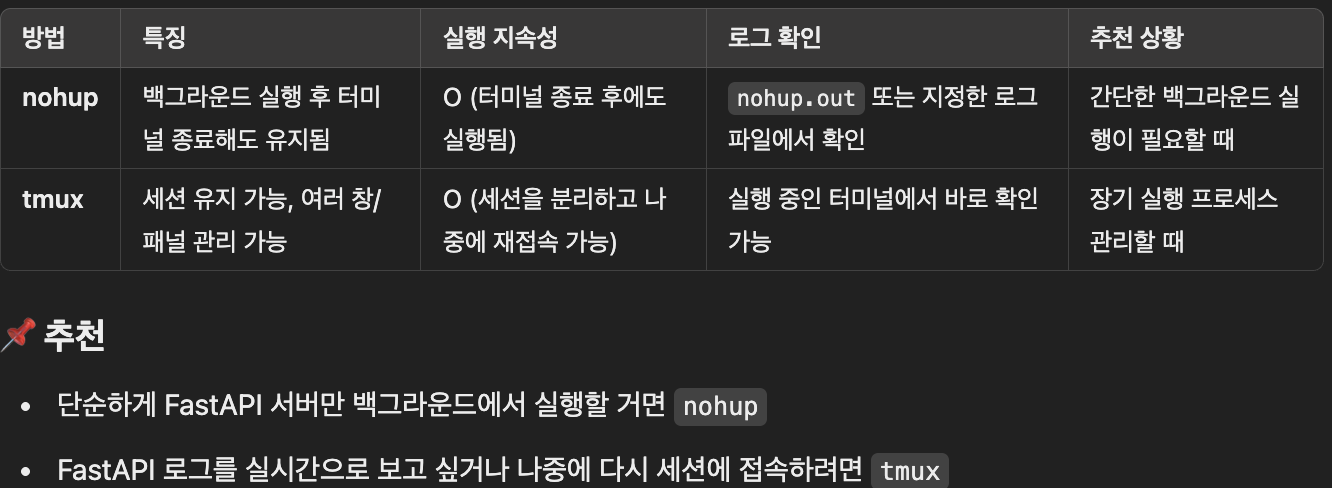

In [4]:
## 폴더 들어가기 
cd /Users/tasha/Desktop/comento/mywork/models/yolov5

## 실행 
tmux new -s fastapi
python /Users/tasha/Desktop/comento/mywork/models/yolov5/fastapi_server.py

## Ctrl + B 누르고 D 키를 누르면 세션이 백그라운드에서 계속 실행
## 재접속
tmux attach -t fastapi

## 필요 없으면 세션 삭제
tmux kill-session -t fastapi

SyntaxError: invalid syntax (3764059219.py, line 2)

### 03. streamlit

In [7]:
# 설치 
#!pip install streamlit

#### 스트림릿 확인 

In [16]:
code = """import streamlit as st
import requests
import PIL.Image as Image
import io

# FastAPI 서버 주소
FASTAPI_URL = "http://127.0.0.1:8000/detect"  # FastAPI 서버 주소 확인

st.title("🚗 차량 탐지 결과 보기")
st.write("이미지를 업로드하면 차량 탐지 결과를 확인할 수 있습니다.")

# 이미지 업로드
uploaded_file = st.file_uploader("이미지를 업로드하세요", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # 이미지 표시
    image = Image.open(uploaded_file)
    st.image(image, caption="업로드한 이미지", use_container_width=True)

    # FastAPI 서버로 이미지 전송
    files = {"file": uploaded_file.getvalue()}
    response = requests.post(FASTAPI_URL, files=files)

    # 결과 출력
    if response.status_code == 200:
        result = response.json()
        st.write("### 📌 탐지된 차량 정보:")

        # 차량 정보 출력
        for detection in result['detections']:
            st.write(f"🚘 차량 탐지: 좌표 ({detection['x1']}, {detection['y1']}) - ({detection['x2']}, {detection['y2']}), 신뢰도 {detection['confidence']:.2f}")

        # FastAPI 결과에서 반환된 이미지 데이터 추출
        img_data = response.content
        img = Image.open(io.BytesIO(img_data))

        # 바운딩 박스가 그려진 이미지를 스트림릿에서 표시
        st.image(img, caption="바운딩 박스가 그려진 이미지", use_container_width=True)

    else:
        st.error("❌ 탐지 실패! FastAPI 서버를 확인하세요.")
"""

# detect_app.py 파일로 저장
file_path = "/Users/tasha/Desktop/comento/mywork/models/yolov5/detect_app.py"
with open(file_path, "w", encoding="utf-8") as f:
    f.write(code)

print(f"✅ detect_app.py 파일이 생성되었습니다! 경로: {file_path}")


✅ detect_app.py 파일이 생성되었습니다! 경로: /Users/tasha/Desktop/comento/mywork/models/yolov5/detect_app.py


#### 터미널에서 아래 실시 

In [11]:
cd /Users/tasha/Desktop/comento/mywork/models/yolov5/
streamlit run detect_app.py

Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: app.py


#### q2. 바운딩박스가.. 스트림릿에서 잘 안 그려지는 것 같습니다. 다른 방법이 있나요?
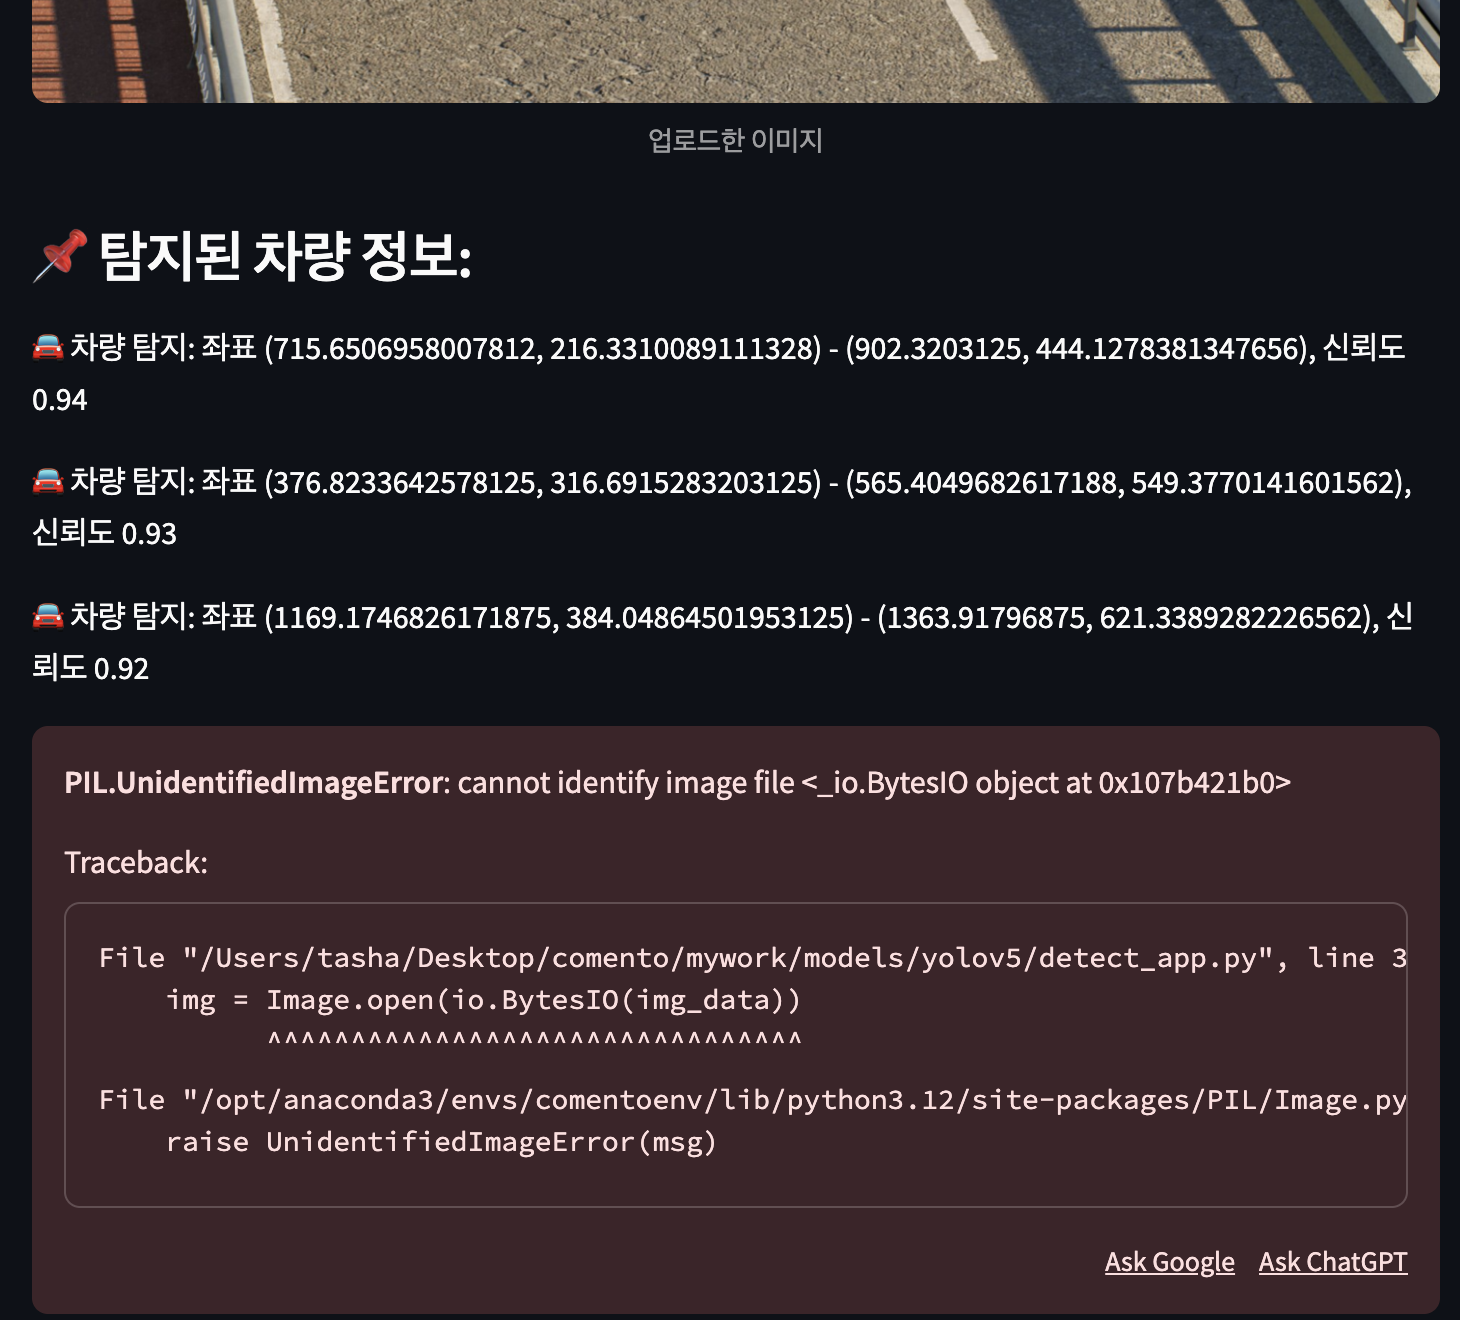